### ROOT $\rightarrow$ NumPy conversion + Preprocessing

We convert the event data stored in the ROOT signal and background files to numpy arrays using the `root_numpy` package. We can control the features we want to train on by extracting the branch names directly from the ROOT TTree and pruning the unwanted branches.

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from root_numpy import root2array, rec2array, array2root
import ROOT
import sys, glob, os, time, random

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

mpl.rcParams.update({'font.size': 12})

In [4]:
def pruned(branch_names):
    # Removes unwanted branches from TTree
    from collections import OrderedDict
    pruned_branches = list(branch_names)
    unwanted = ['hso01', 'hso03', 'Signal', 'VtxProd', 'Delta', 'X', 'Y', 'Z', 'Rho', 'dr', 'dz',
                'nCands', 'iCand', 'Continuum', 'qrMC']
#   unwanted = ['hso01', 'hso03','Signal', 'B0__momDevChi2','X','Y','Z','VtxProd', 'isNot', 'nCands', 'iCand', 'B0__isNotContinuumEvent', 'B0__SigM']
#   unwanted += ['Rho', 'Pvalue', 'dr', 'dz', 'Vert', 'Prob', 'DevChi','momDevChi2']
    for bad_feature in unwanted:
        for feature in branch_names:
            if (bad_feature in feature) and feature in pruned_branches:
                pruned_branches.remove(feature)
                
    return list(OrderedDict.fromkeys(pruned_branches))

In [19]:
def numpy_convert(ROOTfile, treename='b0', B_meson_only = False):
    # Reads selected branches of ROOT files into numpy arrays
    arrayList, branchList = [], []
    loadFile = ROOT.TFile(ROOTfile)
    trees = list(set([key.GetName() for key in loadFile.GetListOfKeys()]))
    
    if B_meson_only:
        trees = [treename]
    
    for tree in trees:
        loadTree = loadFile.Get(tree)
        branches = [b.GetName() for b in loadTree.GetListOfBranches()]
        fullArray = rec2array(root2array(ROOTfile, tree, branches))
        treeArray = fullArray
        #tree_branch_names = pruned(branches)+[branches[0]]
        #treeArray = rec2array(root2array(ROOTfile, tree, tree_branch_names))
        
        if B_meson_only:
            return treeArray, tree_branch_names
        
        arrayList.append(treeArray)
        branchList.append(tree_branch_names)
    
    return arrayList, branchList

In [6]:
# Specify input ROOT files here and the decay mode
sig_ROOT = "ewp/kstar0/B02Kstargammasignal.root"
gen_ROOT = "ewp/kstar0/B02Kstargammageneric.root"
cfd_ROOT = "ewp/kstar0/B02KstargammaX_s.root"
cont_ROOT = "ewp/kstar0/B02Kstargammaqqbar.root"
mode = "kstar0_gamma"
training_mode = 'Continuum' # or 'crossfeed', 'generic'

In [13]:
train_ROOT = '/home/justan/current/jupyter/test/weyland/train_BtoKpi.root'
val_ROOT = '/home/justan/current/jupyter/test/weyland/val_BtoKpi.root'
mode = 'KS0pi0'
training_mode = 'Continuum'

In [ ]:
test, test_branches = numpy_convert(train_ROOT)

In [17]:
test

[]

In [7]:
# Select background, signal data
sig, sig_branches = numpy_convert(sig_ROOT, treename = 'b0')
bkg, bkg_branches = numpy_convert(cont_ROOT, treename = 'b0')

Next we extract the features from the data, and generate truth labels. The complete dataset is stored as a Pandas dataframe for easy access. The dataset is paritioned into training and testing sets twice to ensure no overfitting occurs when we exploit the validation set for hyperparameter tuning.

In [5]:
def create_dataframe(sig, bkg, branch_names):
    # Converts feature representation from numpy to dataframe format
    branch_names = [b.replace("__", "_") for b in branch_names]
    df_sig = pd.DataFrame(sig, columns=branch_names).dropna()
    df_bkg = pd.DataFrame(bkg, columns=branch_names).dropna()
    
    return df_sig, df_bkg

In [ ]:
sig_ROOT = 'higgs/higgs_signal.root'
bkg_ROOT = 'higgs/higgs_background.root'
mode = 'higgs'
training_mode = 'test'

loadFile = ROOT.TFile(sig_ROOT)
trees = list(set([key.GetName() for key in loadFile.GetListOfKeys()]))

for tree in trees:
    loadTree = loadFile.Get(tree)
    branches = [b.GetName() for b in loadTree.GetListOfBranches()]
sig = rec2array(root2array(sig_ROOT, tree, branches))
bkg = rec2array(root2array(bkg_ROOT, tree, branches))

df_sig, df_bkg = create_dataframe(sig, bkg, branches)

In [11]:
df_sig_gamma, df_bkg_gamma = create_dataframe(sig[2], bkg[2], sig_branches[2])
df_sig_B0, df_bkg_B0 = create_dataframe(sig[1], bkg[1], sig_branches[1])
df_sig_kst, df_bkg_kst = create_dataframe(sig[0], bkg[0], sig_branches[0])

In [12]:
df_sig_gamma.head()

,B0_gamma_ECLEnergy,B0_gamma_useCMSFrame_bop_bc,B0_gamma_useCMSFrame_bocosTheta_bc,B0_gamma_useCMSFrame_bophi_bc,B0_gamma_useCMSFrame_boE_bc,B0_gamma_m2Recoil,B0_gamma_eRecoil,B0_gamma_pRecoil,B0_gamma_clusterE9E21,B0_gamma_clusterHighestE,...,B0_gamma_clusterTiming,B0_gamma_clusterReg,B0_gamma_clusterUncorrE,B0_rapidity,B0_gamma_rapidity,B0_pseudoRapidity,B0_gamma_pseudoRapidity,B0_gamma_cosMomVert,B0B0_gamma_hel,B0_gamma_isSignal
0,6.591970,1.980590,-0.126203,0.851374,1.980590,70.019501,8.962743,3.211113,0.982144,1.344502,...,-0.934200,2.0,1.966607,0.349133,0.148748,2.406348,0.148748,-0.994041,-0.548631,1.0
1,8.159471,2.444854,-0.222516,-1.387311,2.444854,60.196083,8.598907,3.707442,0.965805,1.117621,...,0.587035,2.0,2.313200,0.298368,0.053093,2.516929,0.053093,-0.992773,-0.705489,1.0
2,8.159471,2.444854,-0.222516,-1.387311,2.444854,60.196083,8.598907,3.707442,0.965805,1.117621,...,0.587035,2.0,2.313200,0.297462,0.053093,2.419390,0.053093,-0.990174,-0.703555,1.0
3,7.617002,2.306509,0.395081,0.251976,2.306509,63.123356,8.262741,2.269258,0.979646,2.440521,...,-0.436585,2.0,2.617988,0.290019,0.667975,2.461458,0.667975,0.999317,-0.817471,1.0
4,7.320973,2.377859,-0.172582,1.564655,2.377859,61.613659,8.648143,3.629976,0.967787,1.386728,...,-0.906117,2.0,2.267750,0.306129,0.105398,3.105272,0.105398,-0.999854,-0.668134,1.0


In [14]:
df_bkg_gamma['B0_gamma_isSignal'] = df_bkg_B0['B0_isSignal']
df_bkg_gamma.head()

In [16]:
df_bkg_gamma.tail()

,B0_gamma_ECLEnergy,B0_gamma_useCMSFrame_bop_bc,B0_gamma_useCMSFrame_bocosTheta_bc,B0_gamma_useCMSFrame_bophi_bc,B0_gamma_useCMSFrame_boE_bc,B0_gamma_m2Recoil,B0_gamma_eRecoil,B0_gamma_pRecoil,B0_gamma_clusterE9E21,B0_gamma_clusterHighestE,...,B0_gamma_clusterTiming,B0_gamma_clusterReg,B0_gamma_clusterUncorrE,B0_rapidity,B0_gamma_rapidity,B0_pseudoRapidity,B0_gamma_pseudoRapidity,B0_gamma_cosMomVert,B0B0_gamma_hel,B0_gamma_isSignal
613443,7.058359,1.769970,-0.741100,3.088003,1.769970,74.476044,9.586168,4.173556,0.891017,0.659148,...,-1.556013,2.0,1.364044,0.447502,-0.703911,1.854096,-0.703911,-0.585734,0.199232,0.0
613444,4.990127,2.477035,-0.446174,0.932984,2.477035,59.515167,8.687912,3.995579,0.975839,1.893339,...,0.011469,2.0,2.229777,0.391767,-0.195044,2.071042,-0.195044,0.954460,-0.432168,0.0
613445,4.990127,2.477035,-0.446174,0.932984,2.477035,59.515167,8.687912,3.995579,0.975839,1.893339,...,0.011469,2.0,2.229777,0.400283,-0.195044,2.362068,-0.195044,0.986285,-0.349227,0.0
613446,6.447714,2.672688,-0.131267,-1.506530,2.672688,55.375320,8.318066,3.716840,0.963324,2.253832,...,0.047829,2.0,2.583400,0.227760,0.147292,1.328331,0.147292,0.997746,-0.678868,0.0
613447,6.120868,2.920958,-0.253199,-0.370212,2.920958,50.122158,8.067777,3.868703,0.973906,1.962293,...,0.596792,2.0,2.820508,0.259148,0.020215,1.035265,0.020215,0.992248,-0.848627,0.0


In [17]:
df_sig = df_sig_gamma
df_bkg = df_bkg_gamma

In [18]:
df_bkg.head()

,B0_gamma_ECLEnergy,B0_gamma_useCMSFrame_bop_bc,B0_gamma_useCMSFrame_bocosTheta_bc,B0_gamma_useCMSFrame_bophi_bc,B0_gamma_useCMSFrame_boE_bc,B0_gamma_m2Recoil,B0_gamma_eRecoil,B0_gamma_pRecoil,B0_gamma_clusterE9E21,B0_gamma_clusterHighestE,...,B0_gamma_clusterTiming,B0_gamma_clusterReg,B0_gamma_clusterUncorrE,B0_rapidity,B0_gamma_rapidity,B0_pseudoRapidity,B0_gamma_pseudoRapidity,B0_gamma_cosMomVert,B0B0_gamma_hel,B0_gamma_isSignal
0,8.937987,1.656508,0.209880,2.074720,1.656508,76.876793,9.216542,2.840398,0.939208,1.335521,...,-0.467621,2.0,1.719511,0.413273,0.502895,1.603311,0.502895,0.944682,-0.727754,0.0
1,6.919356,2.271328,0.686053,-3.123347,2.271328,63.867756,8.269566,2.125548,0.959783,2.101576,...,-0.329338,2.0,2.563600,0.284711,1.179239,1.880677,1.179239,-0.996117,-0.981276,0.0
2,6.919356,2.271328,0.686053,-3.123347,2.271328,63.867756,8.269566,2.125548,0.959783,2.101576,...,-0.329338,2.0,2.563600,0.195321,1.179239,2.782605,1.179239,0.989618,-0.956598,0.0
3,6.928558,2.604516,-0.048597,-2.909562,2.604516,56.817791,8.437543,3.791351,0.980107,2.059178,...,-0.032606,2.0,2.469179,0.298533,0.240819,1.834509,0.240819,-0.997622,-0.588281,0.0
4,9.832972,2.138345,-0.467819,-2.906013,2.138345,66.681549,9.141628,4.109478,0.923605,1.535497,...,-0.032606,2.0,1.795473,0.174584,-0.236873,1.618670,-0.236873,0.999642,-0.831220,0.0


In [ ]:
# Store dfs in HDF5 format if required
store = pd.HDFStore('/home/justan/current/jupyter/persistance/rho0/dfs/rho0.h5')
store['df_sig'] = df_sig
store['df_cont'] = df_cont
store['df_cfd'] = df_cfd
store['df_cus'] = df_cus
store.close()

### Preprocessing

(Optional) Preprocesses data before it is fed into the deep neural network. Correlated features are removed and data is normalized.

In [19]:
def get_correlated_features(corrmat, corr_threshold = 0.95):
    # Obtains features with correlation coefficient above the specified threshold
    offending_features, correlated_features = [], []
    for column in corrmat.columns:
        if ('deltae' not in column) and ('mbc' not in column):
            for row in corrmat[column].index:
                if ('deltae' not in row) and ('mbc' not in row):
                    if abs(corrmat[column][row]) > corr_threshold and column!=row:
                        offending_features.append([column, row])
    for features in offending_features:
        for feature in features:
            if 'deltae' in feature or 'mbc' in feature:
                offending_features.remove(features)
        if features[::-1] in offending_features:
            offending_features.remove(features)
    for features in offending_features:
        if 'bo0' in features[1]: # Keep properties of the resonance
            correlated_features.append(features[0])
        else:
            correlated_features.append(features[1])
    correlated_features = list(set(correlated_features))
    return correlated_features

In [20]:
def plot_correlations(data, mode):
    # Plot correlation matrix elements between features as a heatmap
    corrmat = data.corr()
    f, ax = plt.subplots(figsize=(14,11))
    sns.heatmap(corrmat, square=True, cmap='RdBu')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    f.tight_layout()
    plt.title(r"$\mathrm{Correlation \; Coefficients \; " + mode + "}$")
    f.savefig('graphs/' + mode + 'correlations.pdf',  format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

In [21]:
def df_norm_std(df):
    # Remove mean, scale to unit variance
    from sklearn import preprocessing
    stdScaler = preprocessing.StandardScaler()
    df_norm = pd.DataFrame(stdScaler.fit_transform(df[df.columns[:-1]]), columns = df.columns[:-1])
    df_norm['labels'] = df[df.columns[-1]].values

    return df_norm

In [22]:
def df_preprocessing(df):
    # Center data, normalize scale to [-1,1] along each feature
    from sklearn.preprocessing import scale 
    feature_columns = df.columns[:-1]
    
    # df_centered = pd.DataFrame(preprocessing.scale(df[feature_columns], with_mean = True, with_std = False), columns = feature_columns)
    df_centered = df[feature_columns] - df[feature_columns].mean()
    scaler = preprocessing.MaxAbsScaler()
    df_pre = pd.DataFrame(scaler.fit_transform(df_centered[feature_columns]), columns = feature_columns)
    df_pre['labels'] = df[df.columns[-1]].values
    
    return df_pre.assign(labels = df['B0__isSignal'].values)

Define the background type you want the classifier to train on. Default options: light quark continuum, crossfeed from misreconstructed $b \rightarrow s \gamma$, $B \bar{B}$ generic. You can add your own. Certain decay channels will have a significant background from topologically identical and kinematically similar modes. The classifier should be trained to identify this as background.

In [23]:
# Remove correlated features from DataFrame
correlated_features = get_correlated_features(df_sig.corr(), corr_threshold=0.95) + ['B0_mbc', 'B0_deltae']
df_sig_raw = df_sig.copy()
df_bkg_raw = df_bkg.copy()

for feature in correlated_features:
    del df_sig[feature]
    del df_bkg[feature]

KeyError: 'B0_mbc'

In [ ]:
plot_correlations(df_sig.drop(df_sig.columns[-1],1), 'SIG')

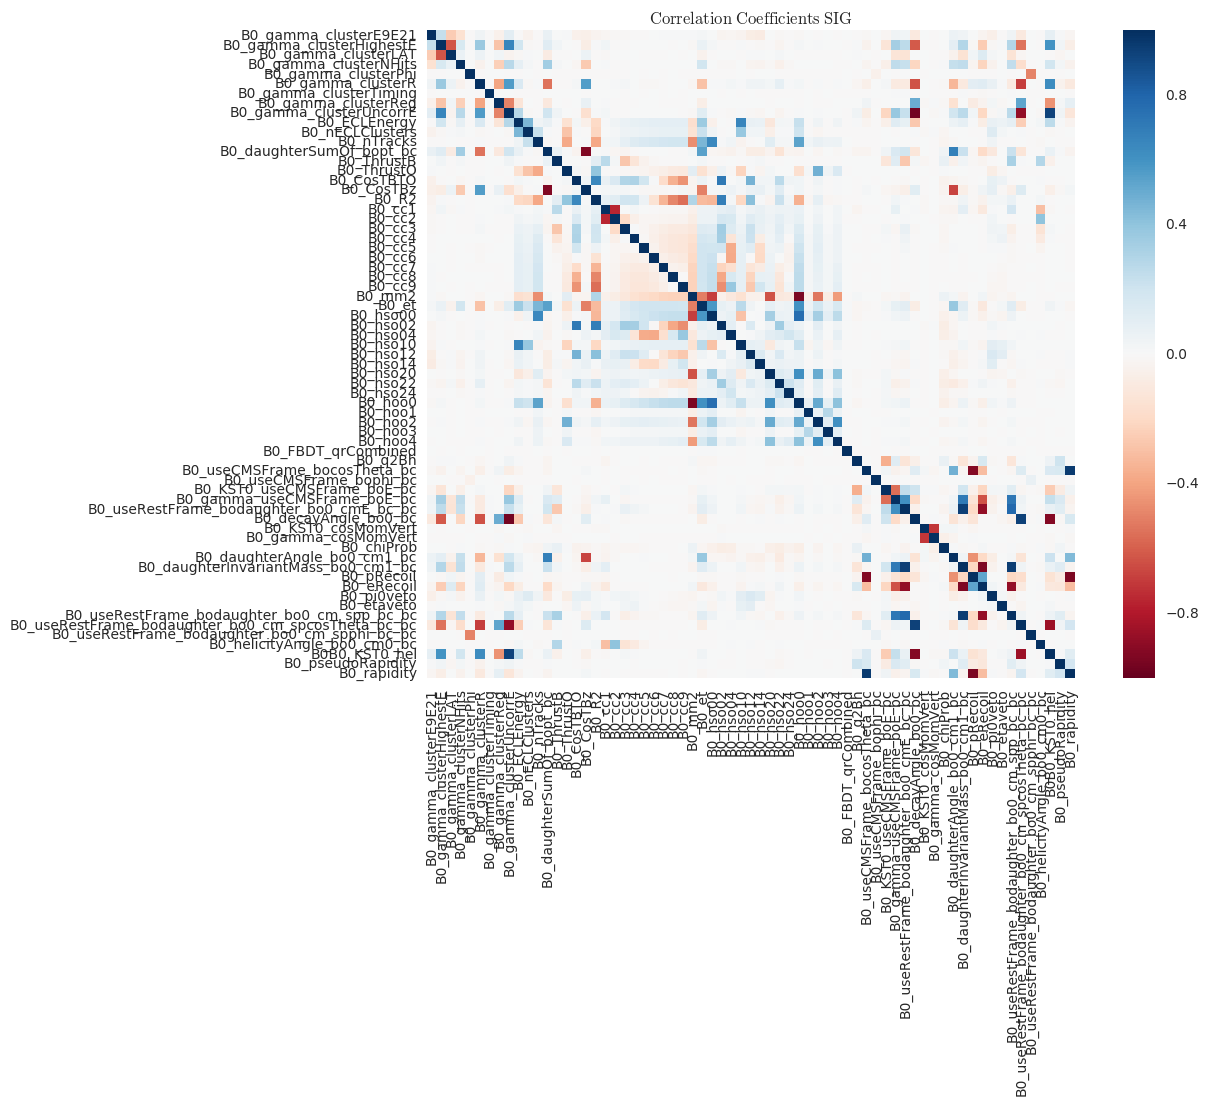

In [39]:
plot_correlations(df_sig.drop(df_sig.columns[-1],1), 'SIG')

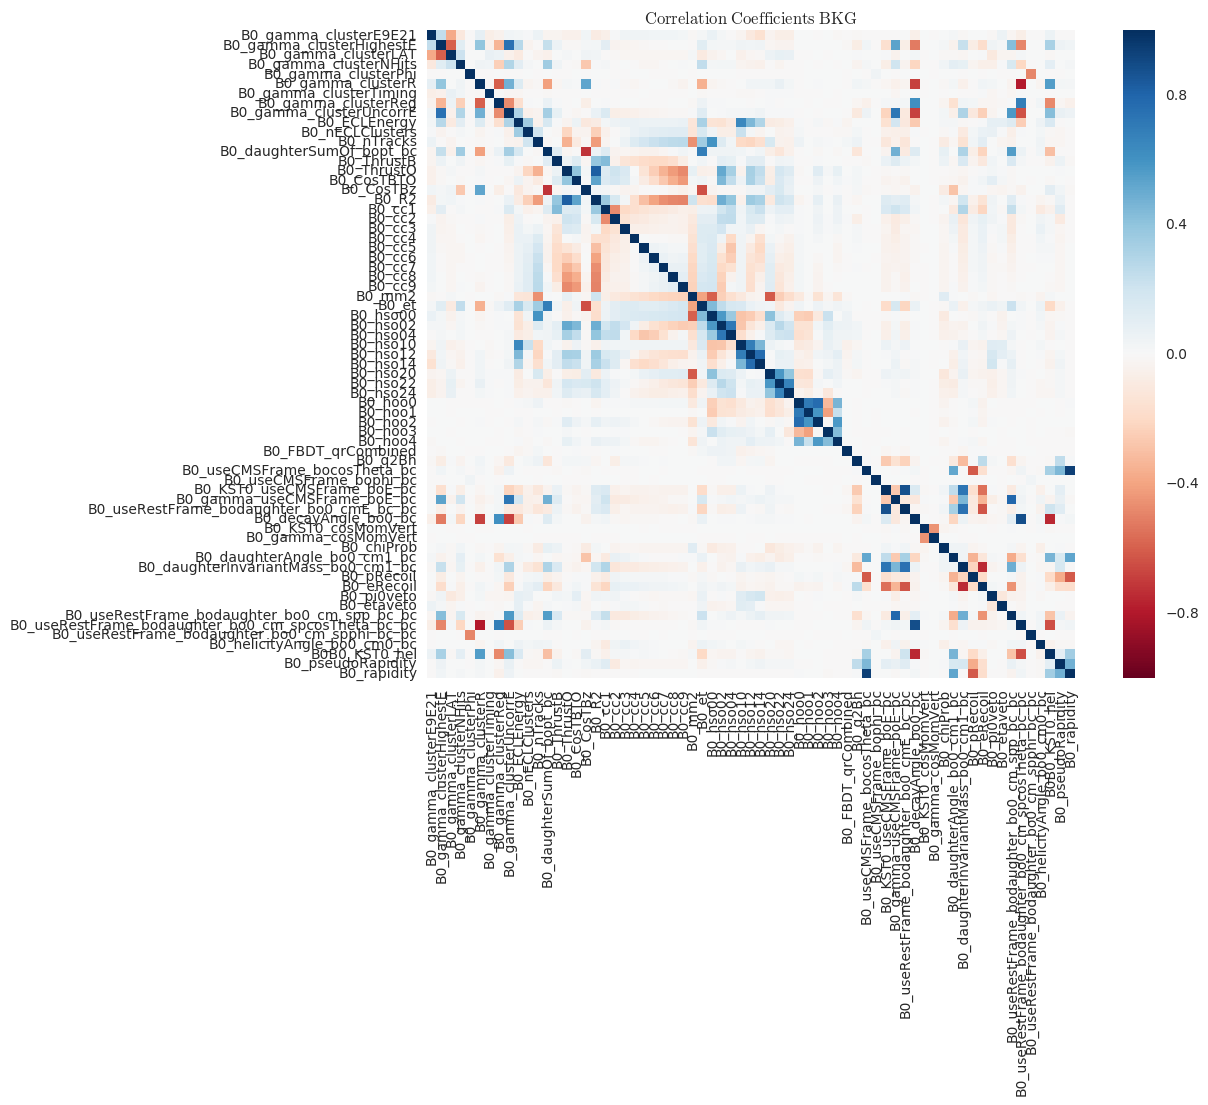

In [40]:
plot_correlations(df_bkg.drop(df_sig.columns[-1],1), 'BKG')

In [81]:
frames = [df_sig,df_bkg]
df_composite = pd.concat(frames, ignore_index = True) #, keys = ['signal', 'background'])

In [82]:
df_composite_norm = df_norm_std(df_composite)
df_composite_norm.describe()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,...,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,labels
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,...,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1000000.000000
mean,-3.204099e-16,-2.658040e-17,-1.765188e-16,-1.170037e-16,2.012701e-17,-1.824950e-16,6.875389e-18,-2.195255e-17,-5.478931e-14,1.260927e-16,...,-3.655598e-17,6.930865e-14,-4.440692e-17,-2.862266e-16,3.298407e-16,-3.721297e-16,9.409986e-16,1.813649e-17,-3.833718e-16,0.529673
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000000e+00,1.000001e+00,...,1.000001e+00,1.000000e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.499119
min,-1.268620e+00,-2.415476e+00,-1.731496e+00,-1.664895e+00,-1.731583e+00,-1.793340e+00,-2.938436e+00,-1.731013e+00,-9.732187e-01,-1.607830e+00,...,-1.731149e+00,-7.132886e-01,-1.388404e+00,-2.080317e+00,-5.830471e+00,-2.142754e+00,-1.761245e+00,-1.999792e+00,-1.944267e+00,0.000000
25%,-7.093250e-01,-7.317815e-01,-8.659471e-01,-7.038208e-01,-8.653274e-01,-6.568063e-01,-6.813376e-01,-8.627212e-01,-9.732187e-01,-6.718212e-01,...,-8.654016e-01,-7.132886e-01,-3.623988e-01,-4.701506e-01,-3.941212e-01,-6.096652e-01,-5.699418e-01,-5.861660e-01,-6.051798e-01,0.000000
50%,-2.439476e-01,4.277515e-04,1.361513e-03,-1.777613e-01,-2.253908e-04,-2.028872e-01,-1.897842e-04,1.654738e-04,8.401751e-02,-2.048238e-01,...,-3.514153e-03,-7.132886e-01,-2.073018e-01,-1.957182e-01,-3.696564e-01,-2.348121e-01,-1.898701e-01,-2.353424e-01,-2.812420e-01,1.000000
75%,4.342010e-01,7.316710e-01,8.647037e-01,4.923007e-01,8.664473e-01,3.790705e-01,6.809581e-01,8.640493e-01,1.141254e+00,4.177556e-01,...,8.656463e-01,1.503225e+00,-1.475435e-02,1.541140e-01,-1.844283e-01,3.327605e-01,3.165383e-01,2.942092e-01,3.172916e-01,1.000000
max,1.366167e+01,2.414400e+00,1.734114e+00,1.485899e+01,1.732038e+00,1.555991e+01,2.940017e+00,1.730137e+00,1.141254e+00,2.130324e+01,...,1.735256e+00,1.503225e+00,4.469970e+01,3.847296e+01,2.963338e+01,2.459574e+01,2.429788e+01,2.122119e+01,1.692014e+01,1.000000


Save to file. Load into classifier in separate notebook.

In [48]:
filename = 'kstar0_norm_sig_cont.h5'

store = pd.HDFStore(os.path.join('/home/justan/current/jupyter/persistance', mode, 'dataframes', filename))
store['df'] = df_composite_norm
store.close()

### Feature Visualization

In [44]:
def truncate_tails(hist, nsigma = 5):
    # Removes feature outliers above nsigma stddevs away from mean
    hist = hist[hist > np.mean(hist)-nsigma*np.std(hist)]
    hist = hist[hist < np.mean(hist)+nsigma*np.std(hist)]
    return hist

In [45]:
def compare_histograms_overlay(data_sig, data_bkg, nbins = 50, columns=None):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'
    crimson_tide = '#cc0000'
    yellow = '#ffff00'
    orange = '#ffa500'

    
    for variable in columns:      
        d_sig = truncate_tails(data_sig[variable].values,5)
        d_bkg = truncate_tails(data_bkg[variable].values,5)
        
        sns.distplot(d_sig,color = sea_green, hist=True,label = r'$\mathrm{Signal}$',bins=nbins)       
        sns.distplot(d_bkg,color = steel_blue, hist=True,label = r'$\mathrm{Background}$',kde=False,norm_hist=True,bins=nbins)

#         sns.kdeplot(data_array_bkg, color = steel_blue, label = 'Background',shade =True)
#         sns.kdeplot(d_cfd, color = crimson_tide, label = 'Crossfeed',shade =True)
#         sns.kdeplot(d_gen, color = yellow, label = 'Generic',shade =True)

        plt.title(variable)
        plt.autoscale(enable=True, axis='x', tight=False)
        plt.xlabel(variable)
        plt.ylabel(r'$\mathrm{Normalized \; events/bin}$')
        plt.legend(loc = "best")
        #plt.title(r"$\mathrm{"+variable+"{\; - \; (B \rightarrow K^+ \pi^0) \gamma$")
        #plt.xlim(-1.0,0.98)
        #plt.ylim(0,3.3)
        #plt.xlabel(r'$|(p_B)_{CMS}| \; [GeV/c]$')
        #plt.savefig('graphs/' + mode + variable + '.pdf', bbox_inches='tight',format='pdf', dpi=1000)
        plt.show()
        plt.gcf().clear()

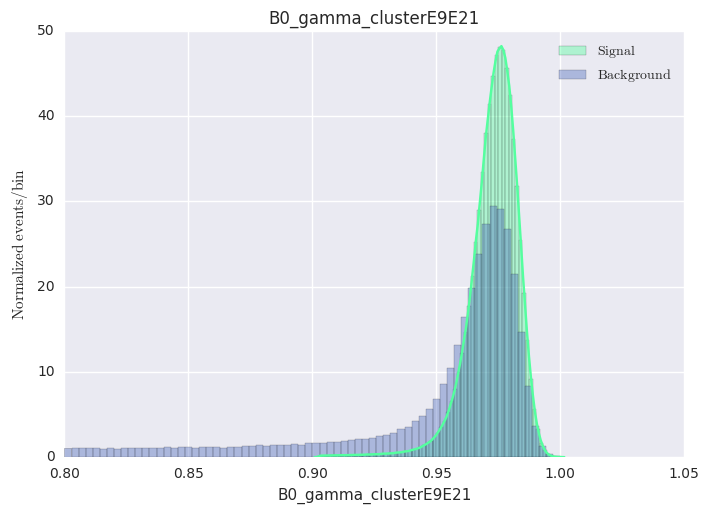

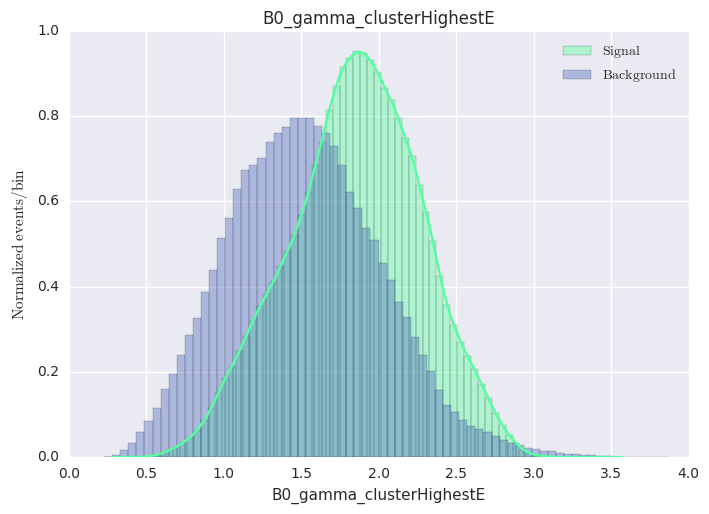

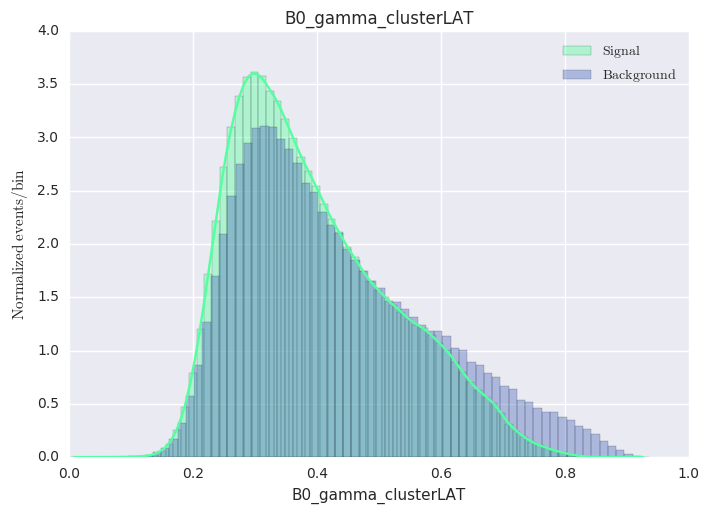

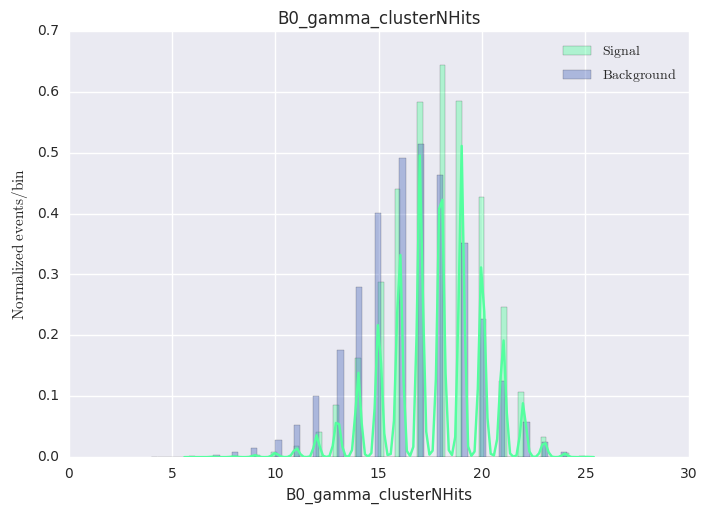

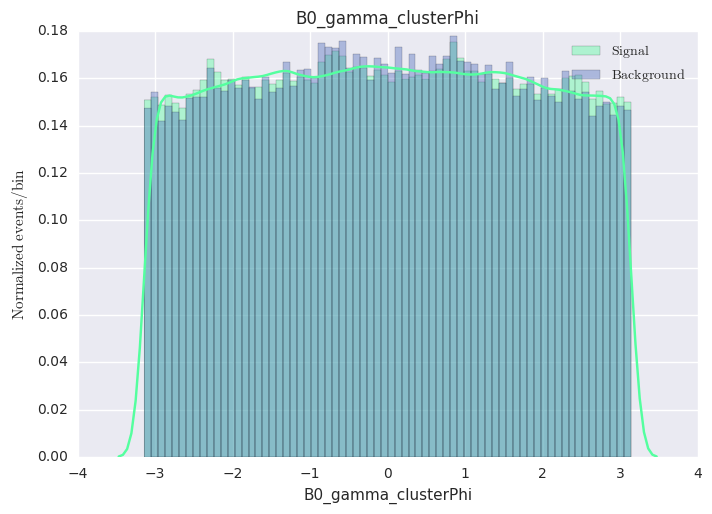

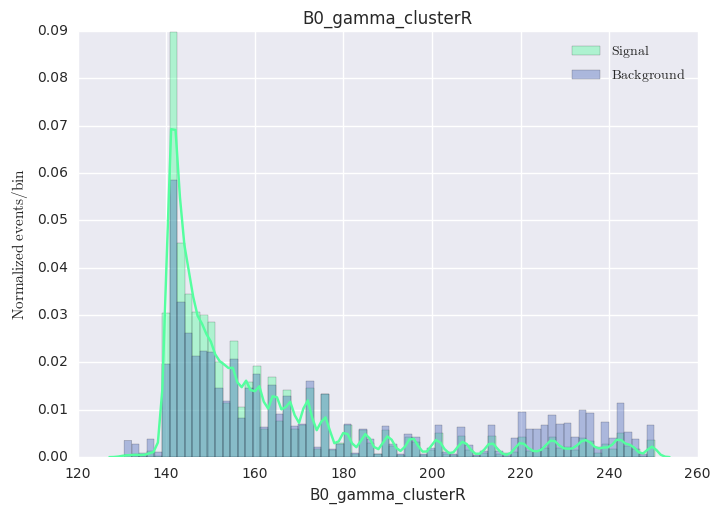

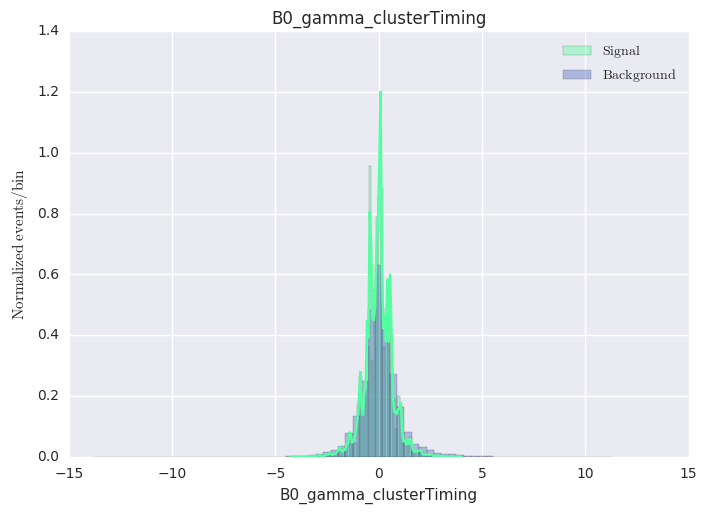

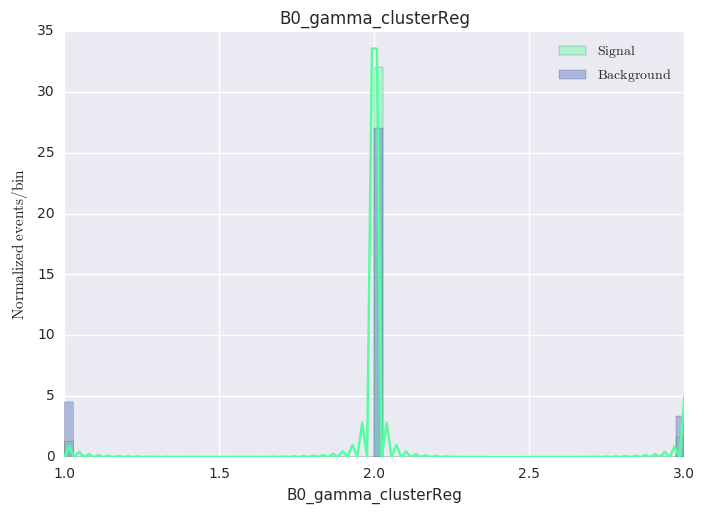

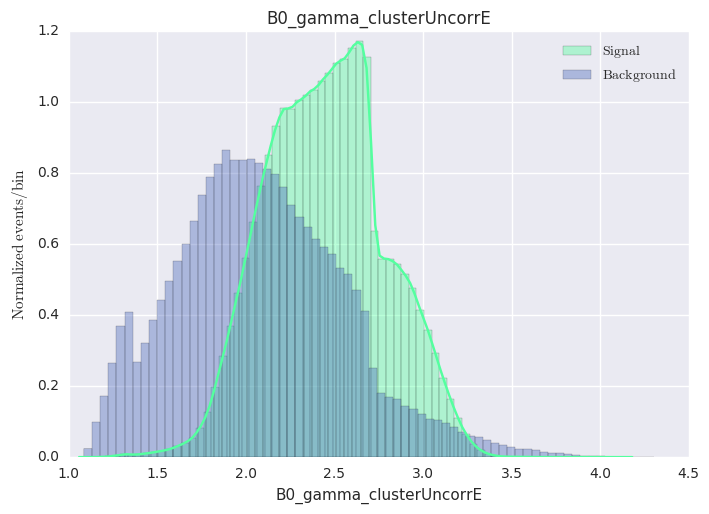

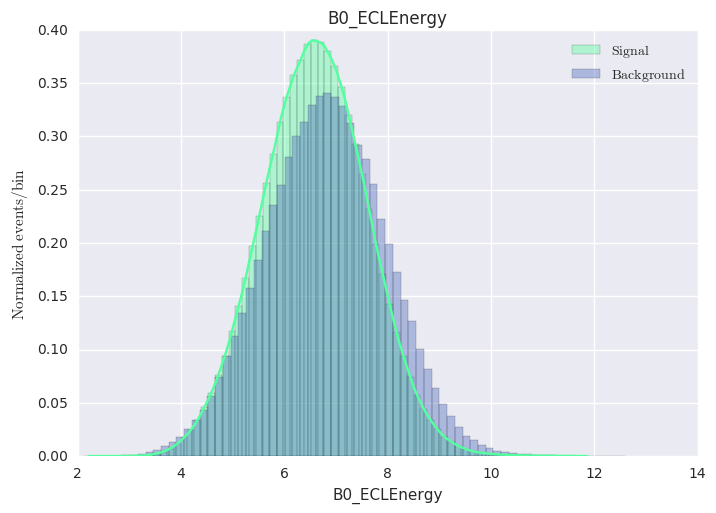

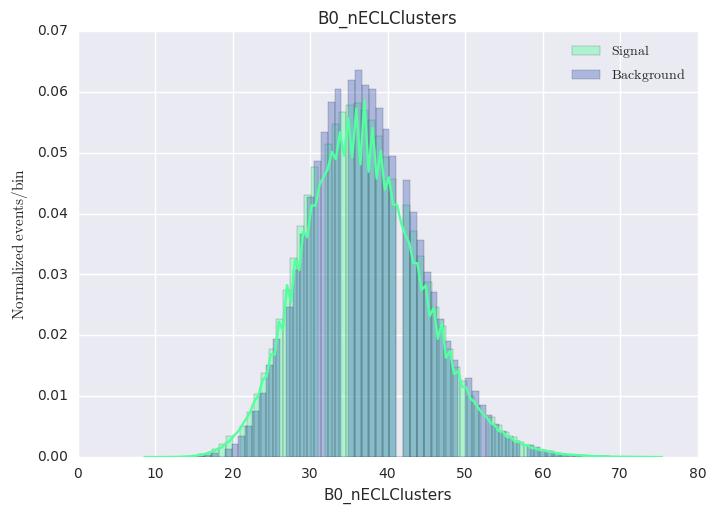

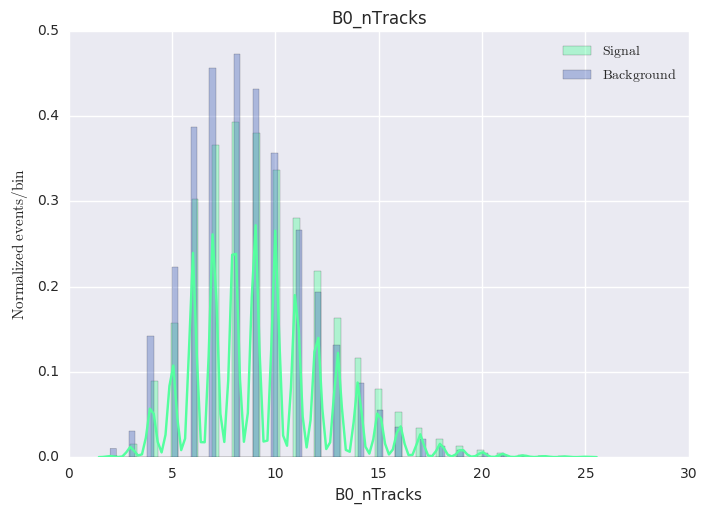

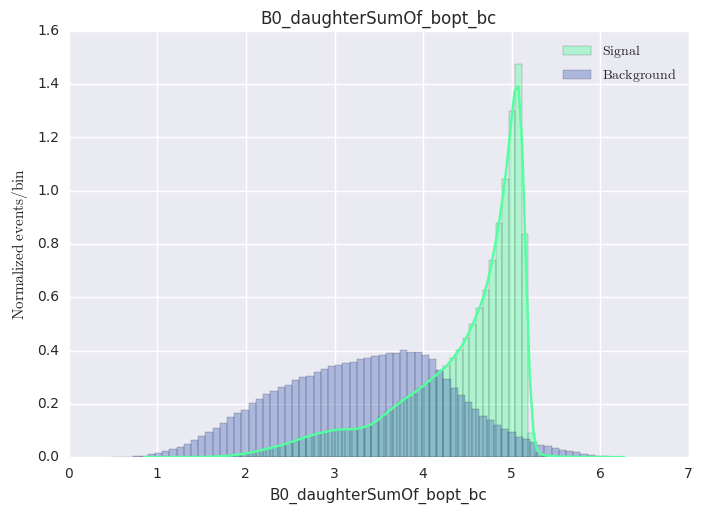

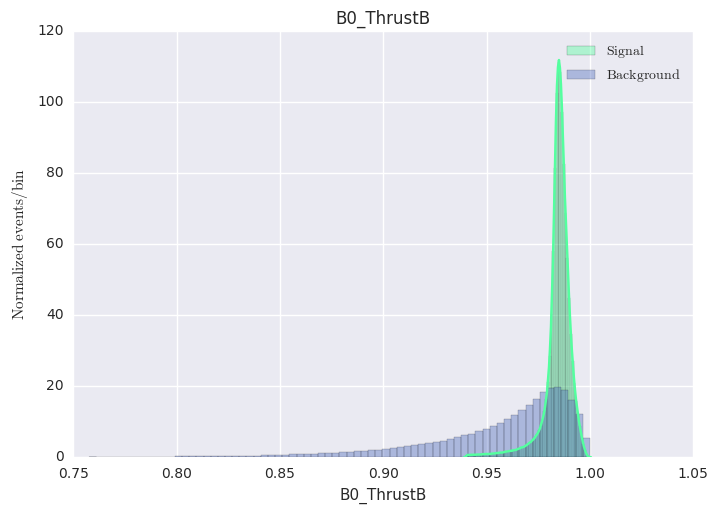

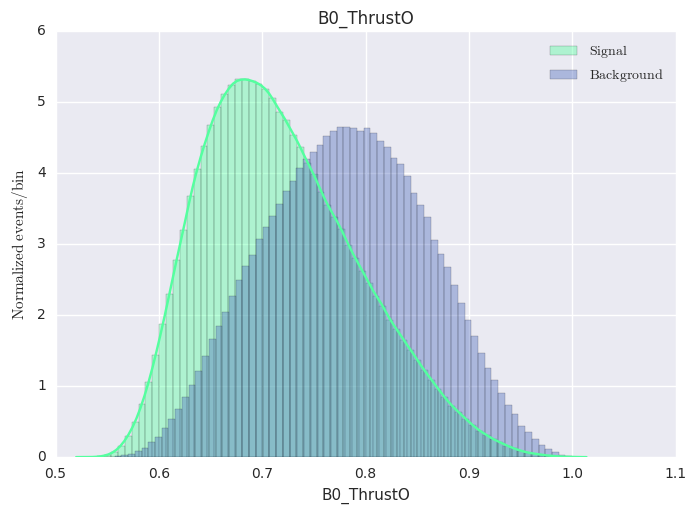

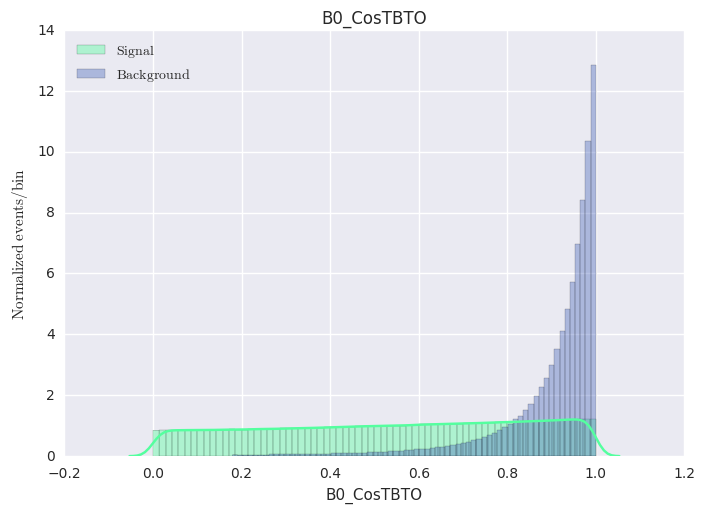

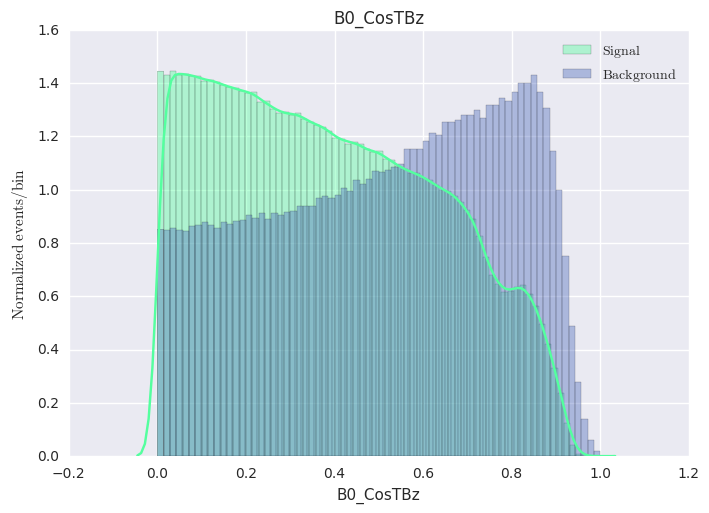

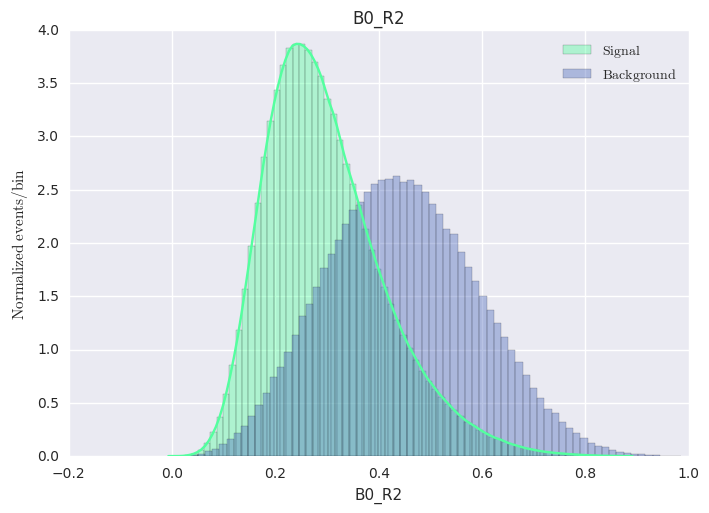

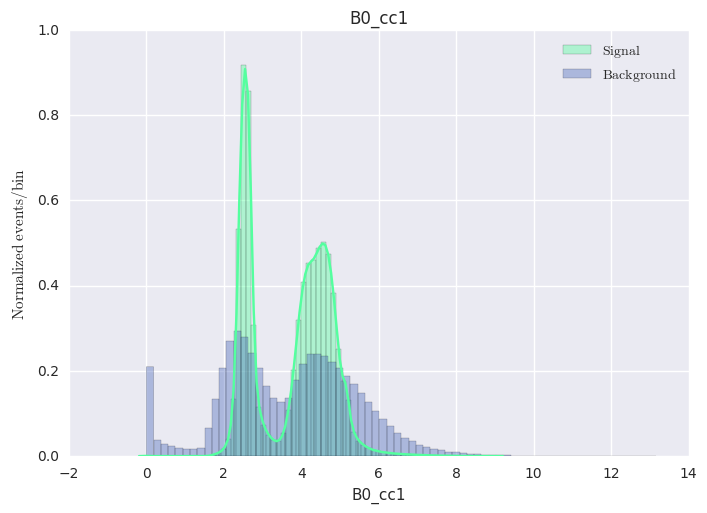

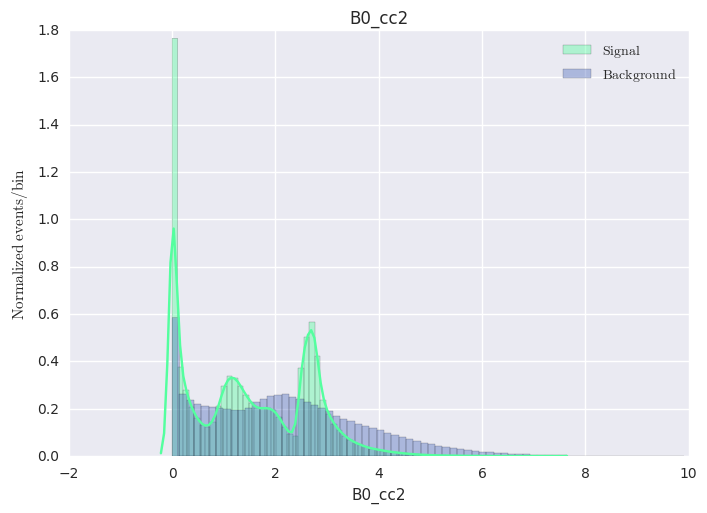

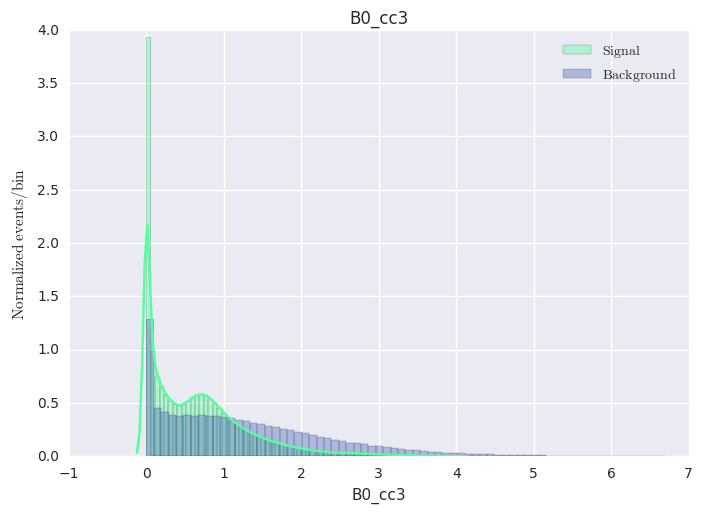

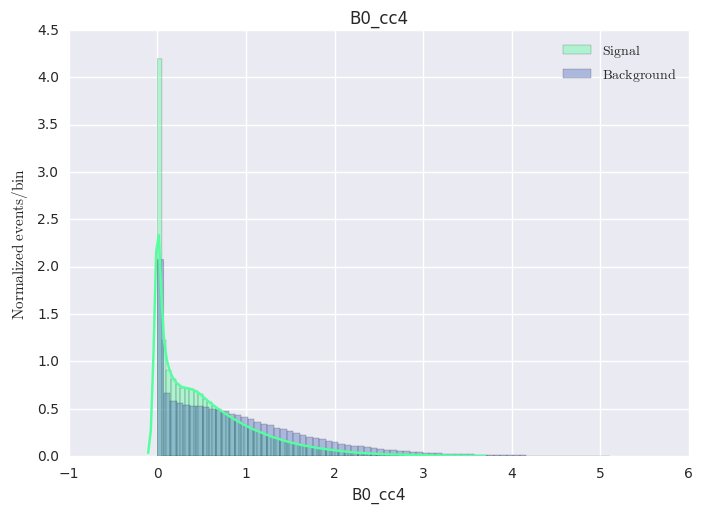

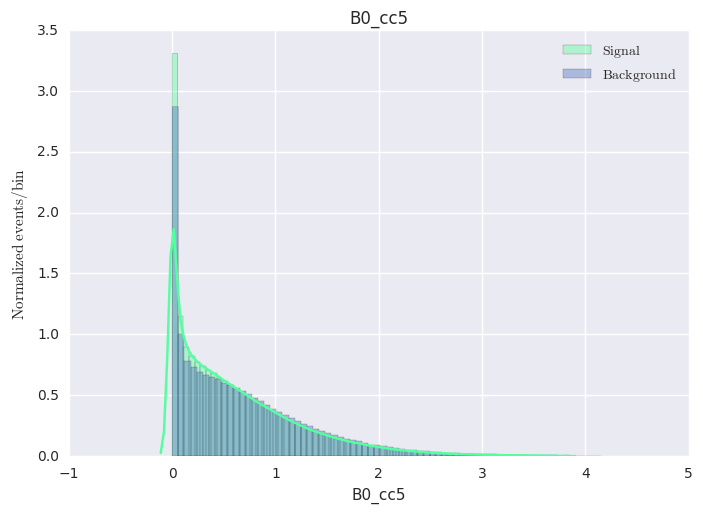

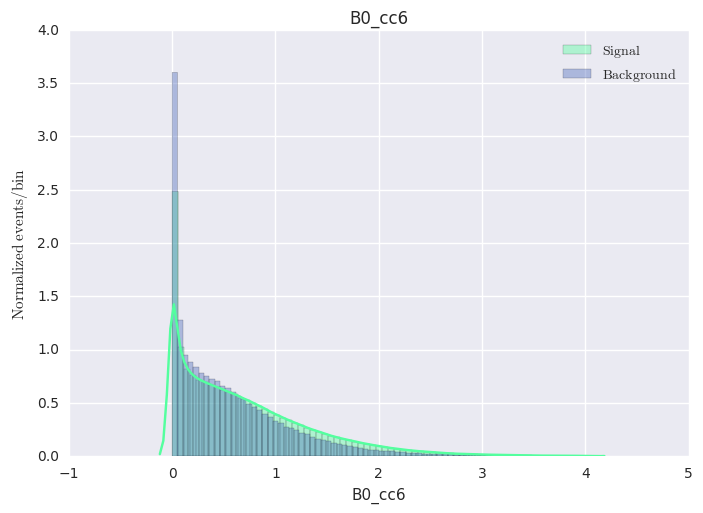

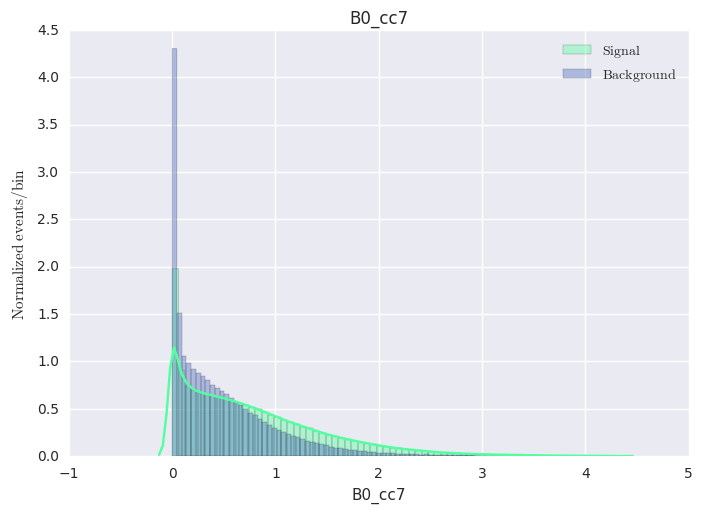

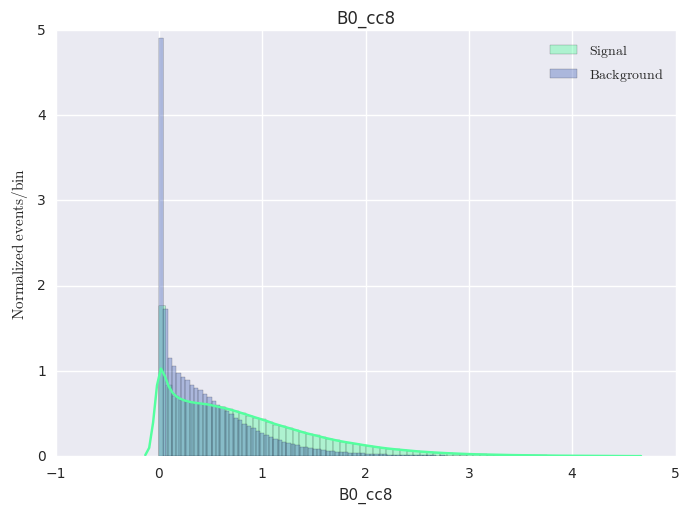

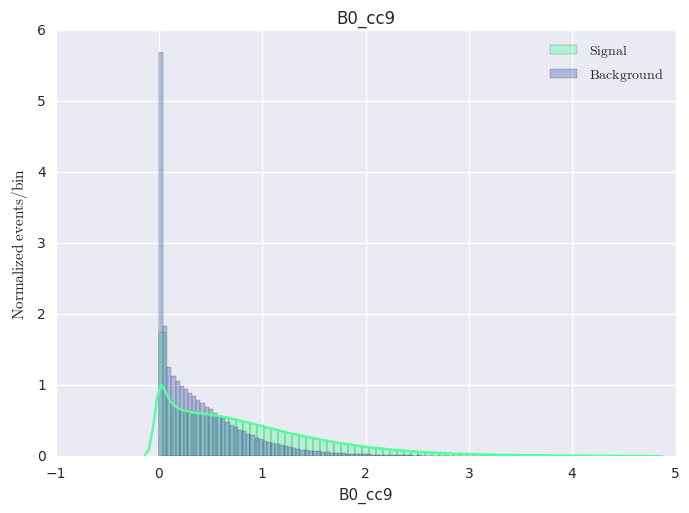

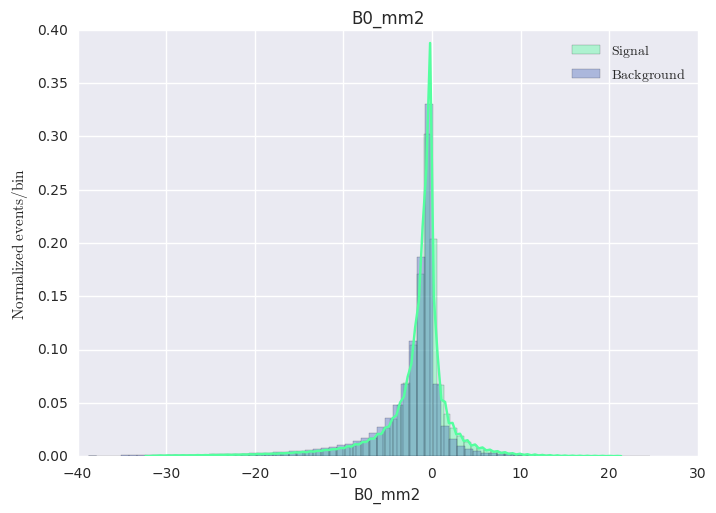

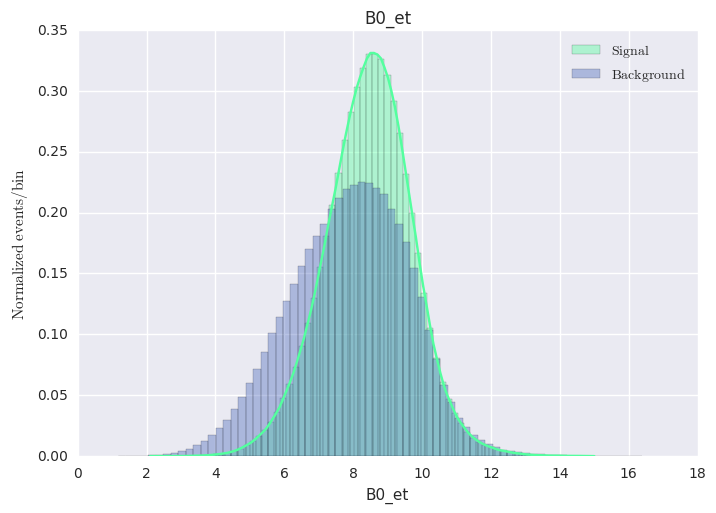

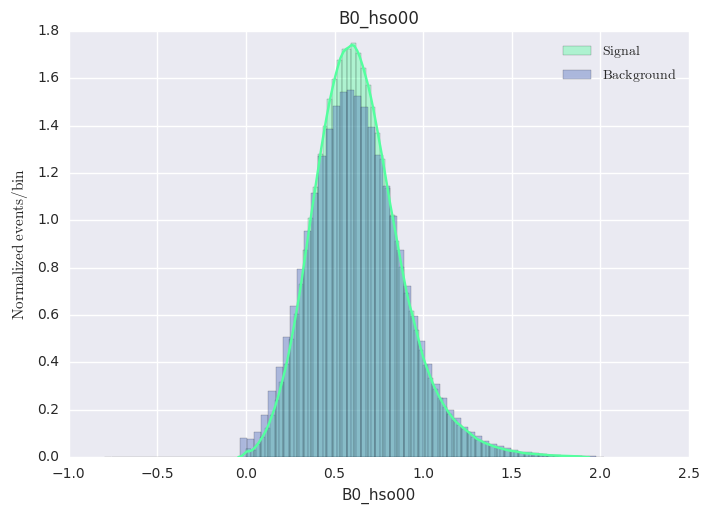

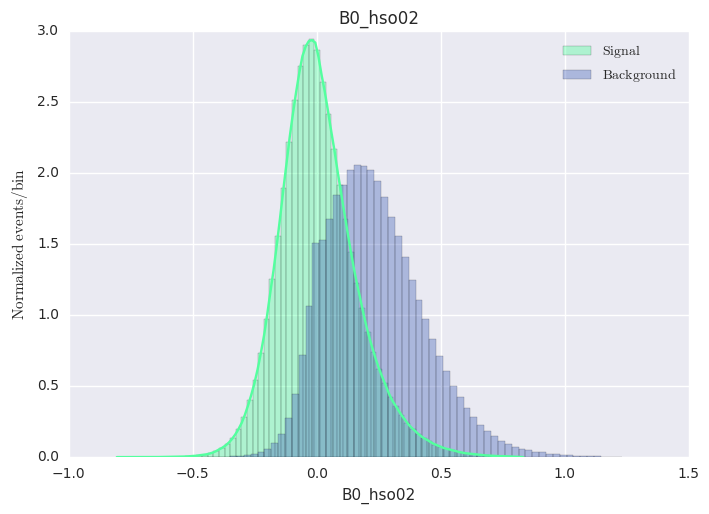

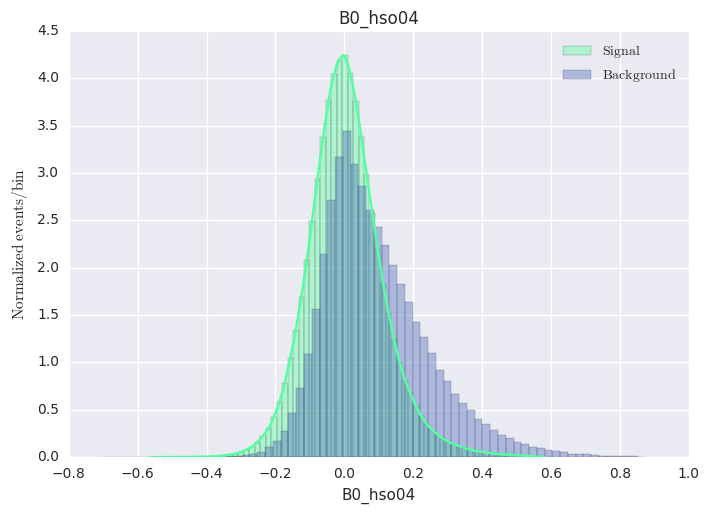

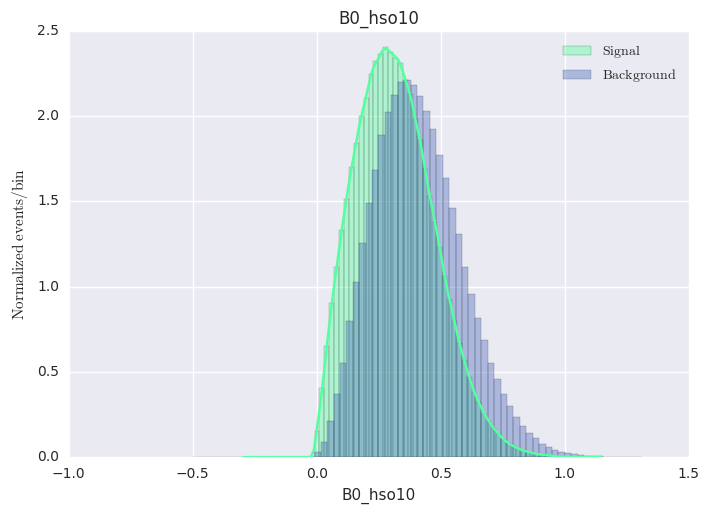

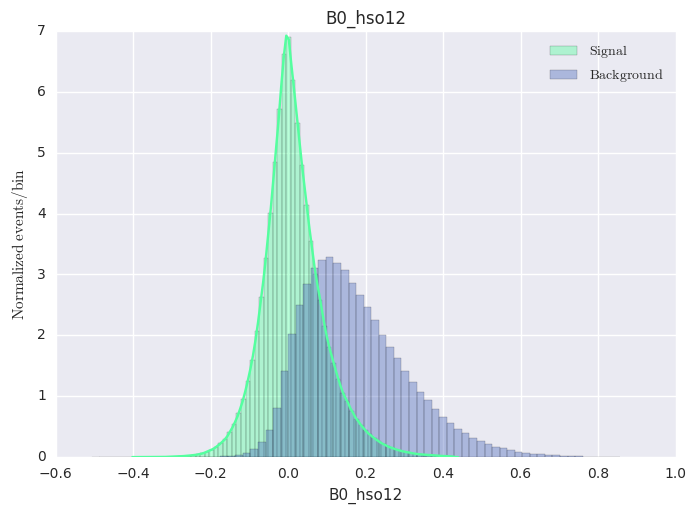

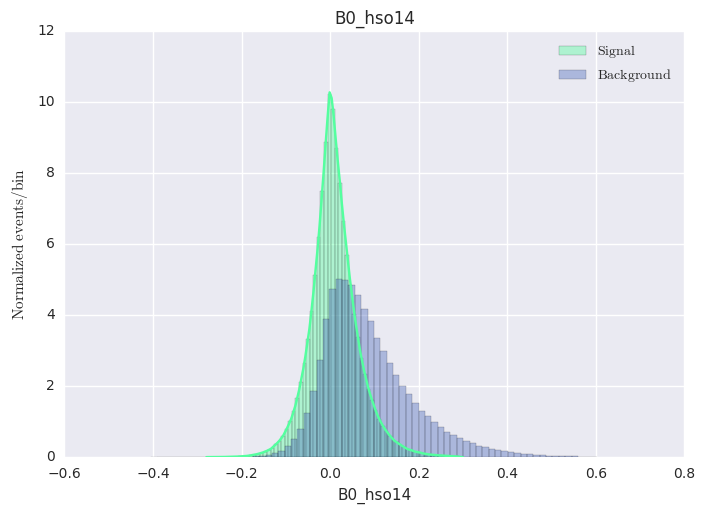

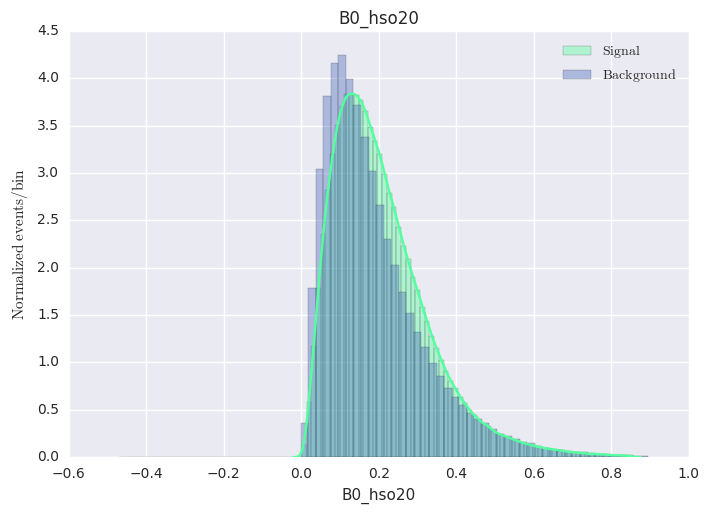

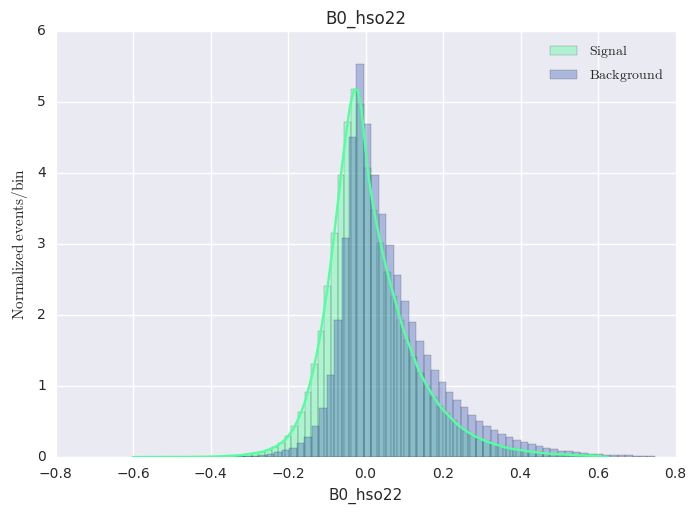

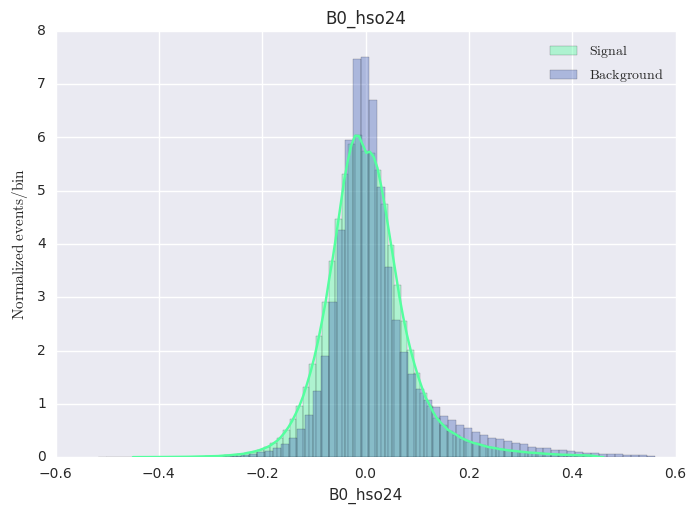

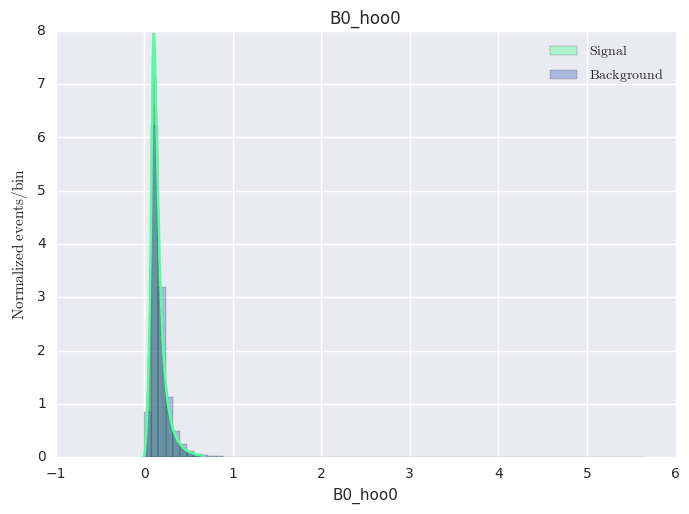

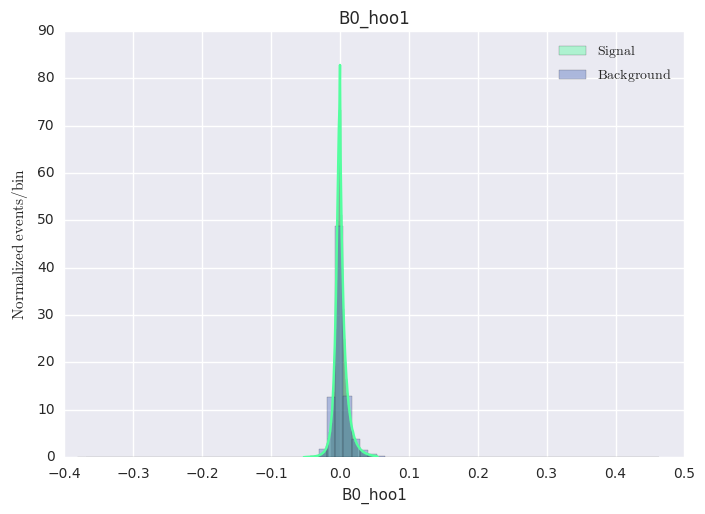

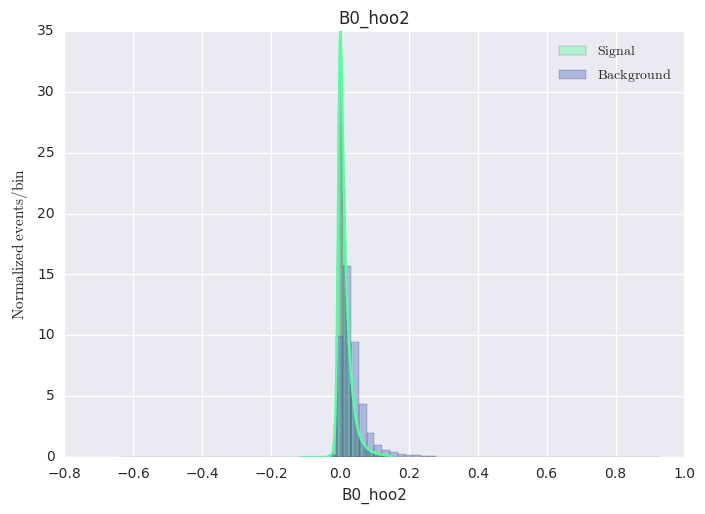

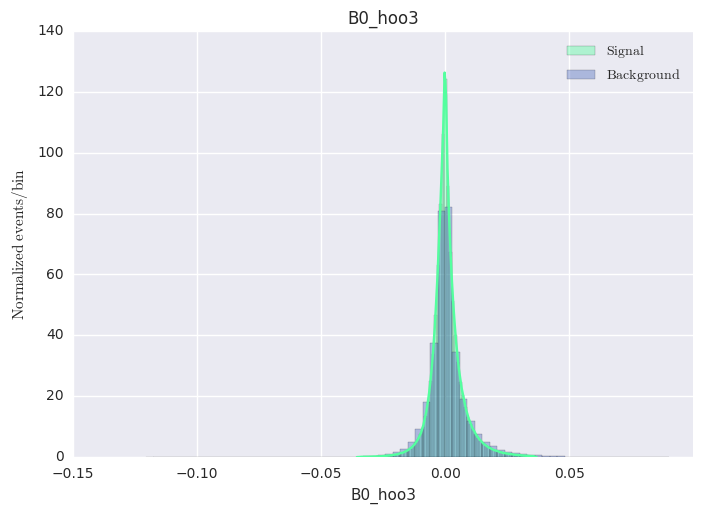

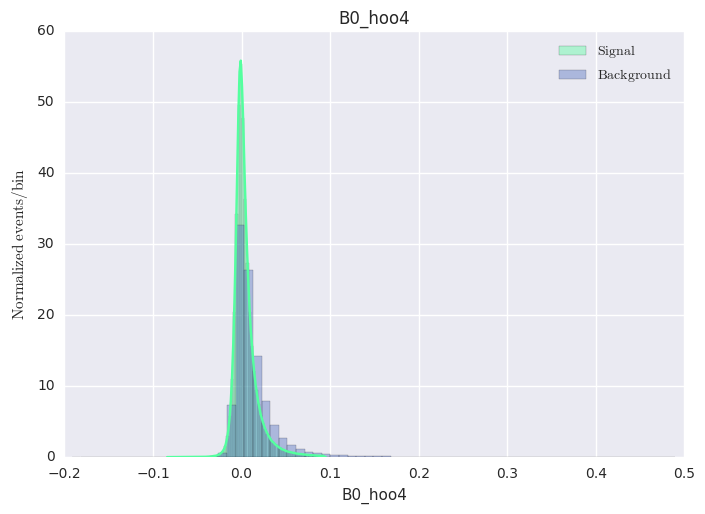

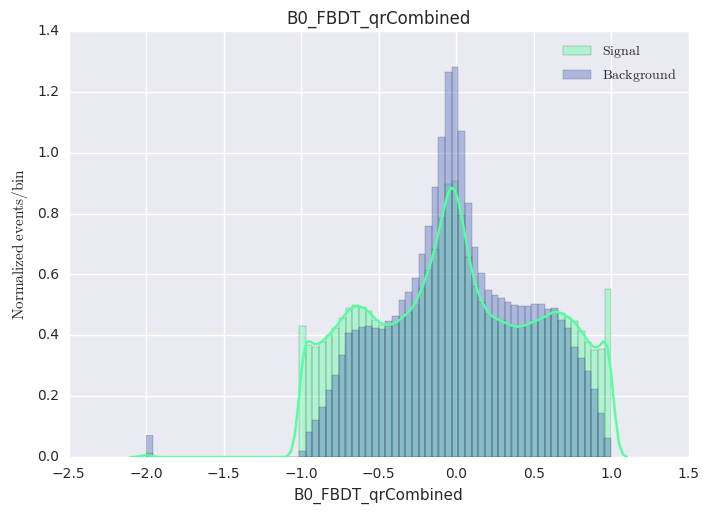

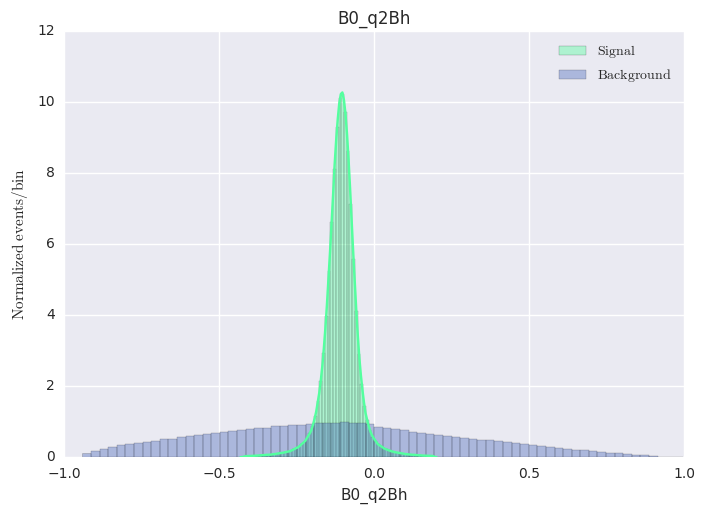

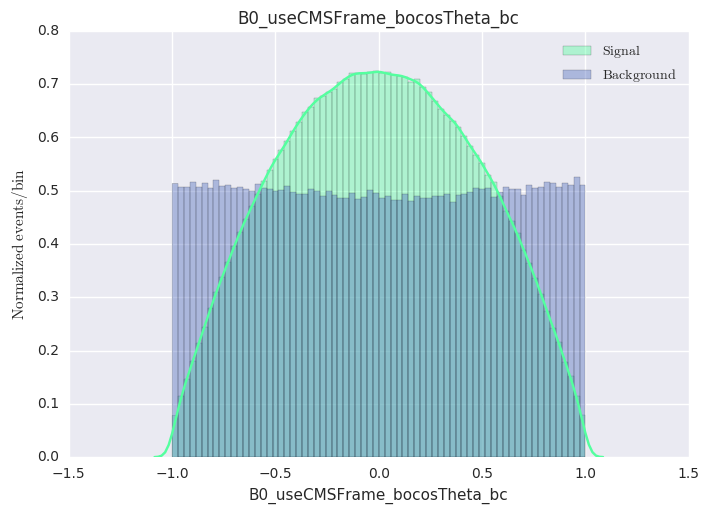

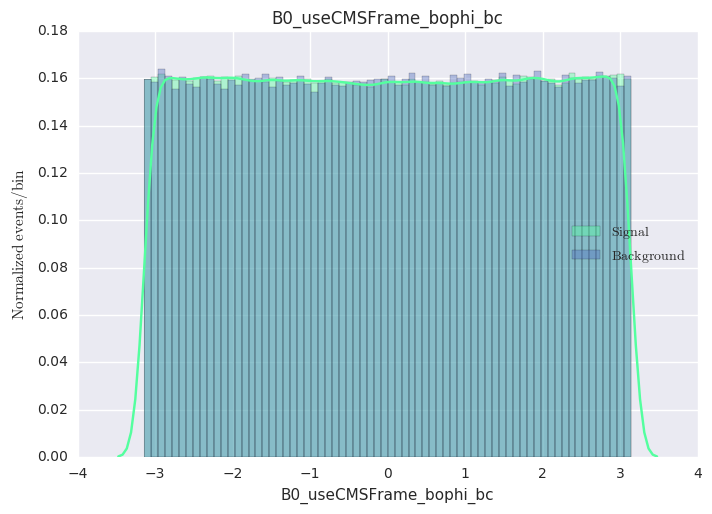

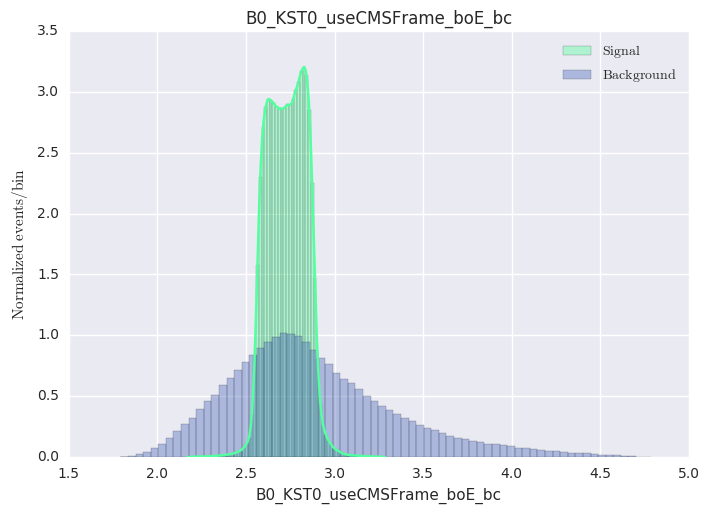

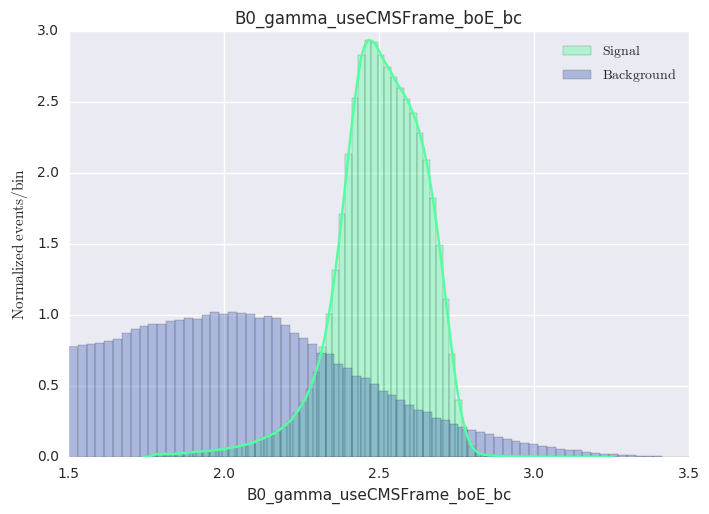

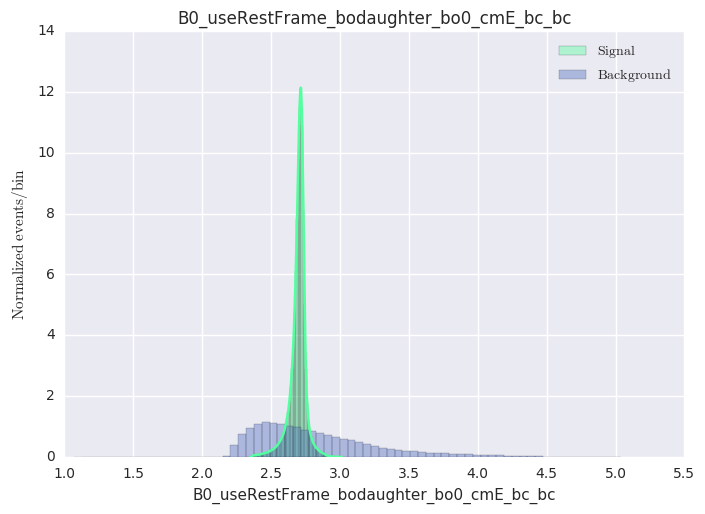

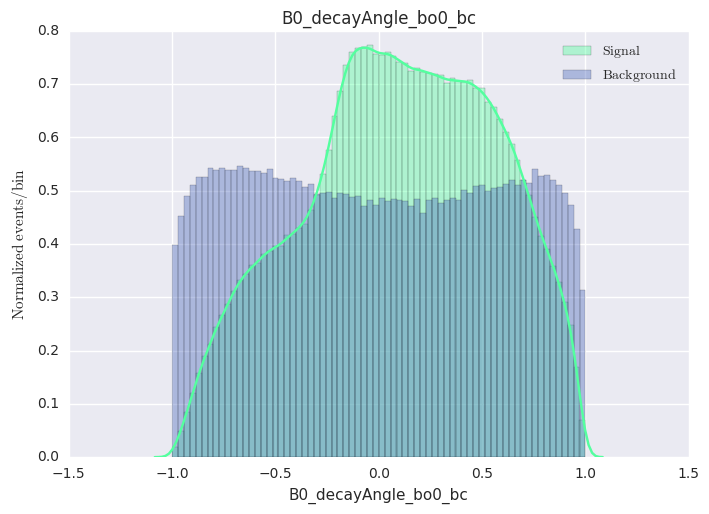

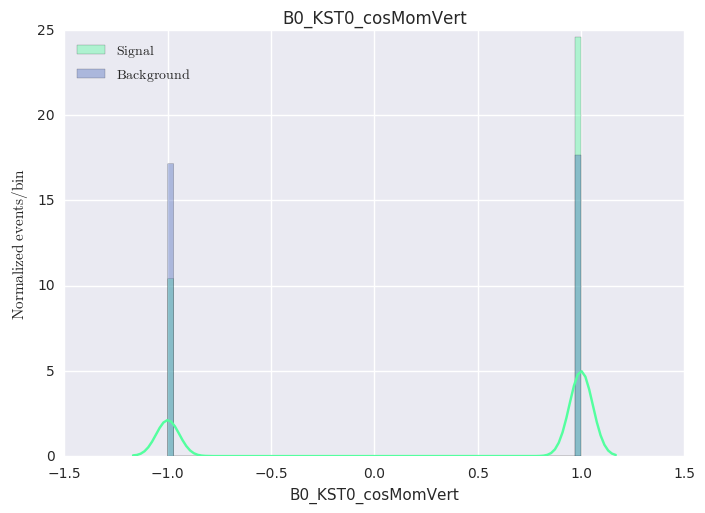

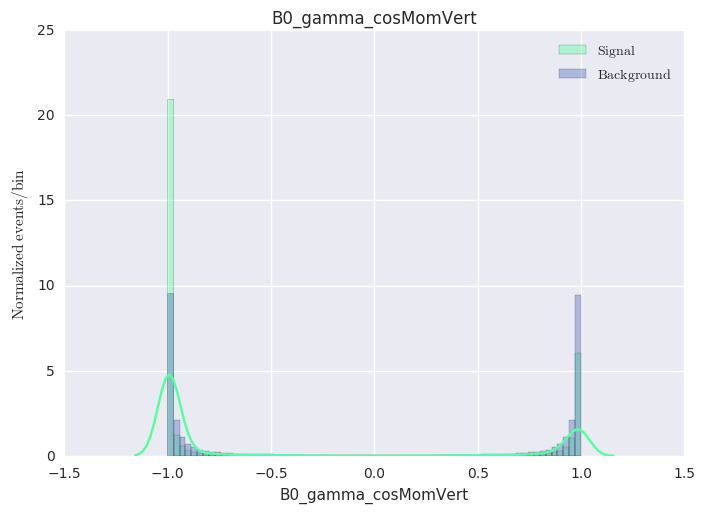

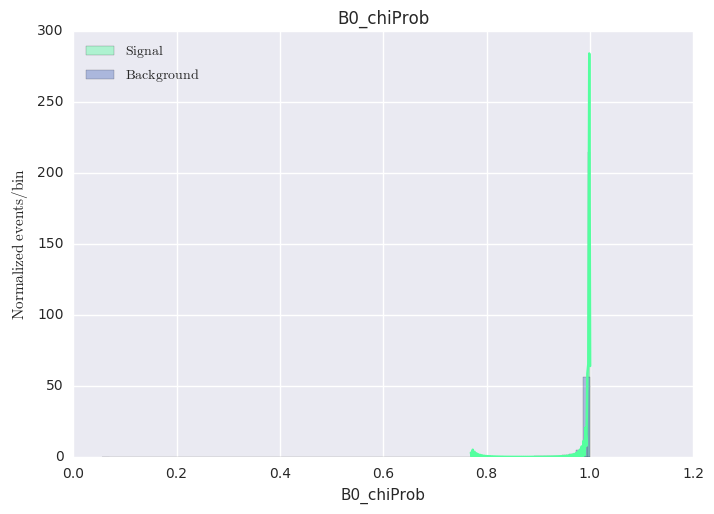

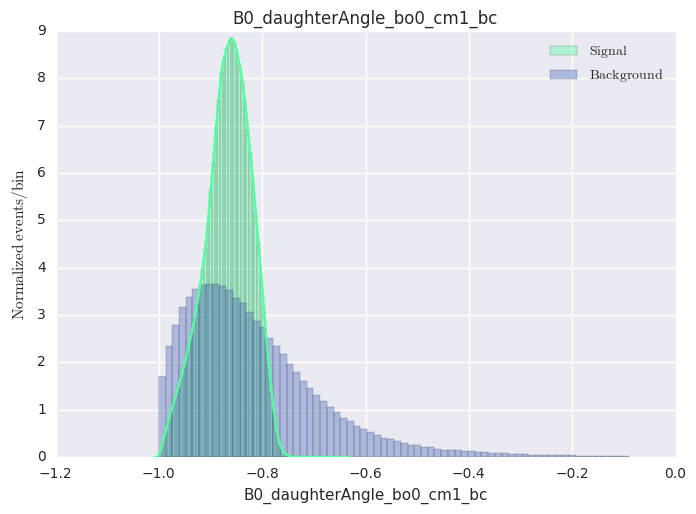

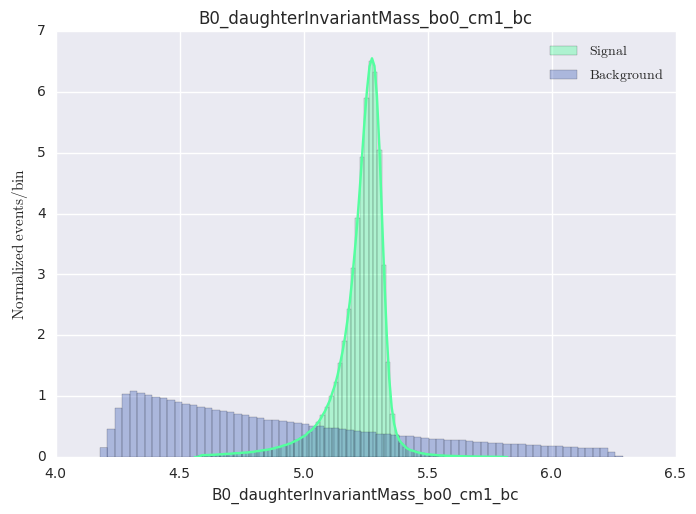

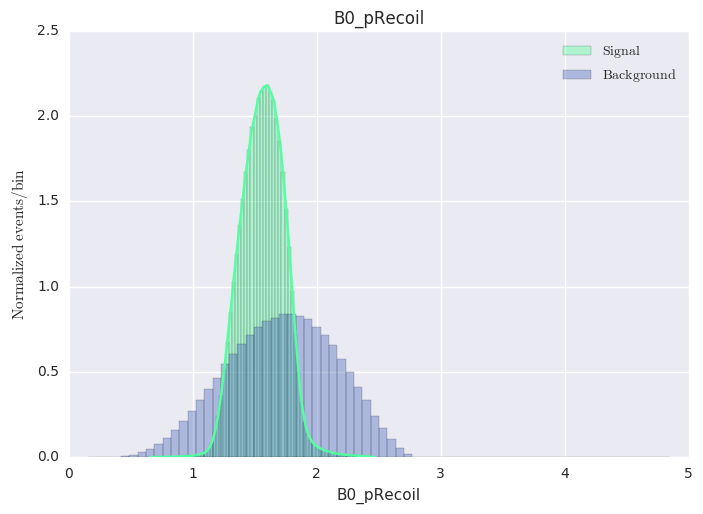

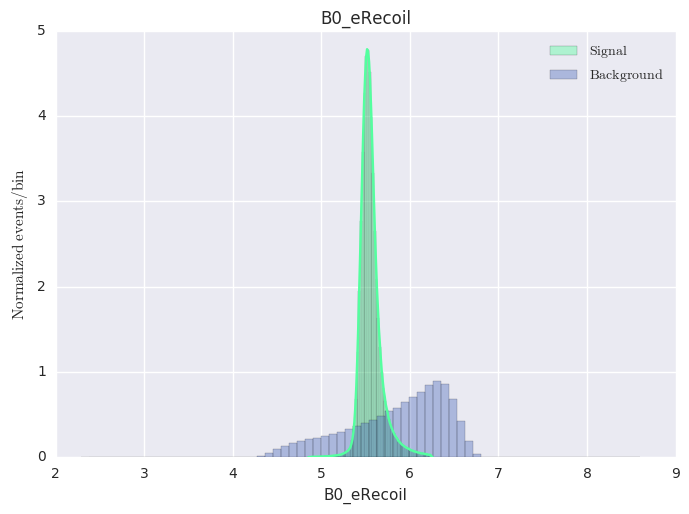

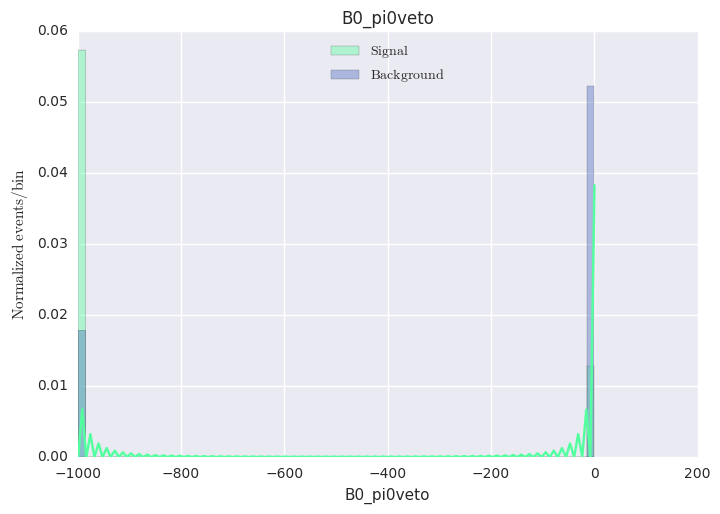

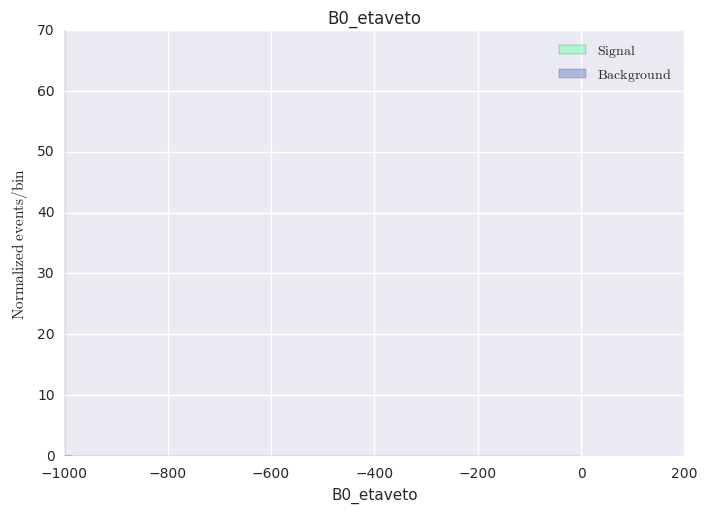

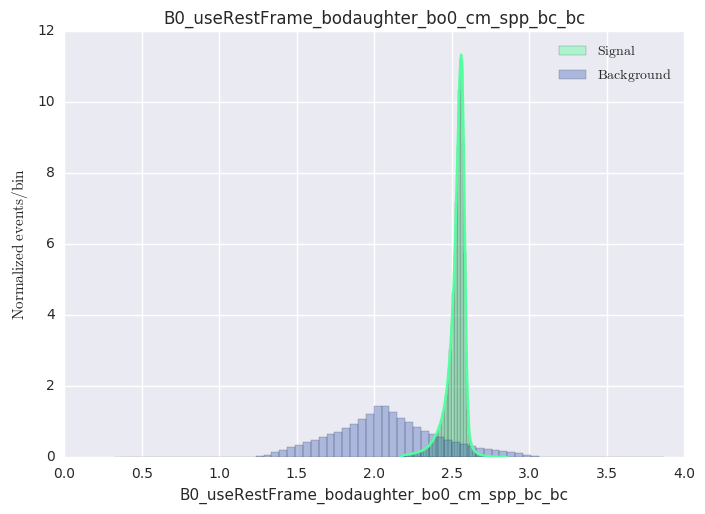

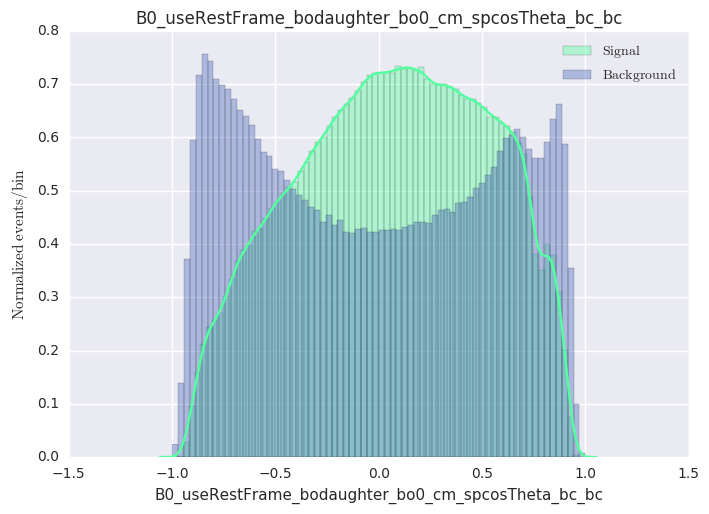

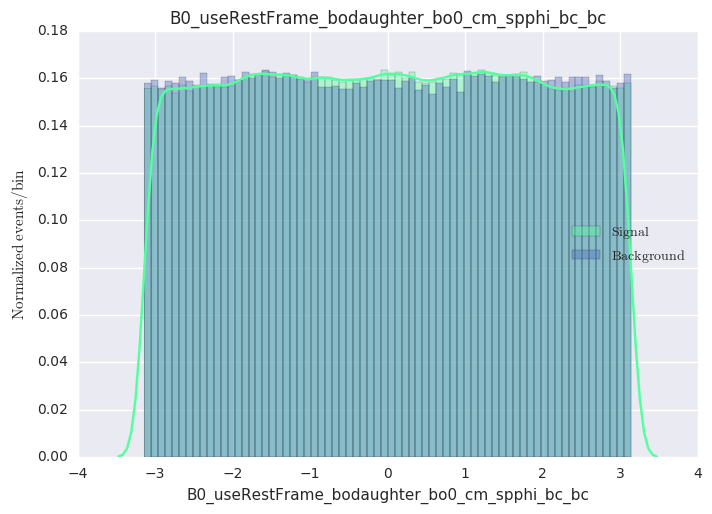

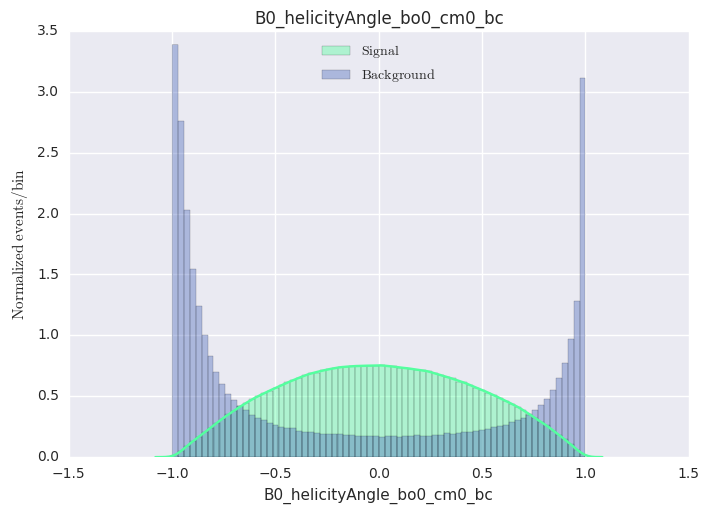

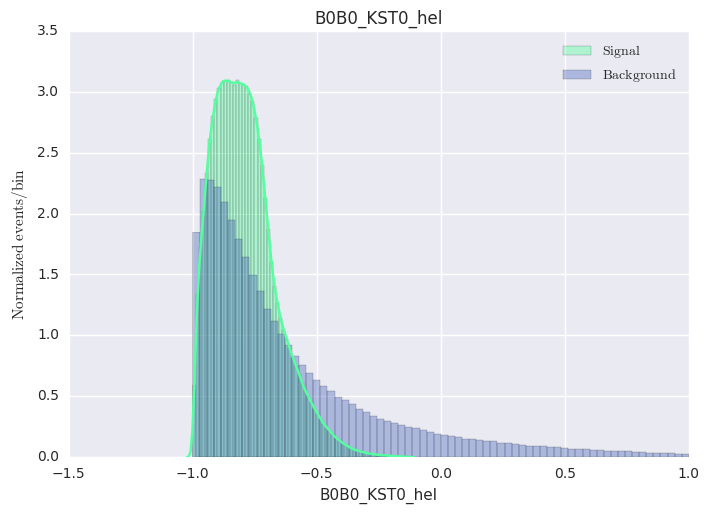

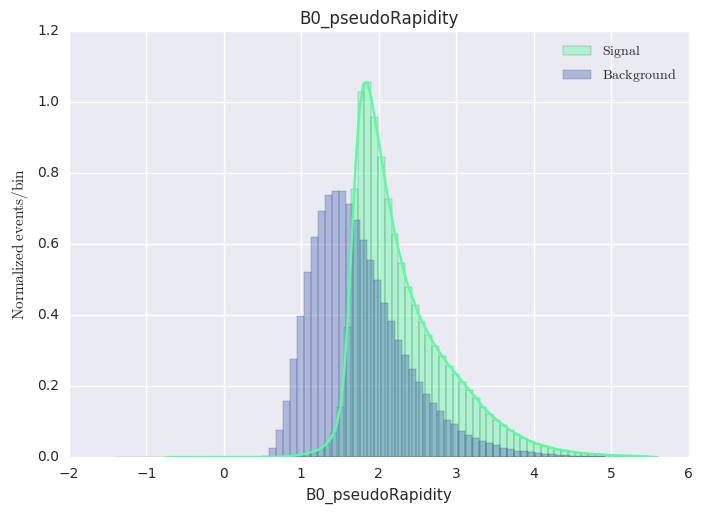

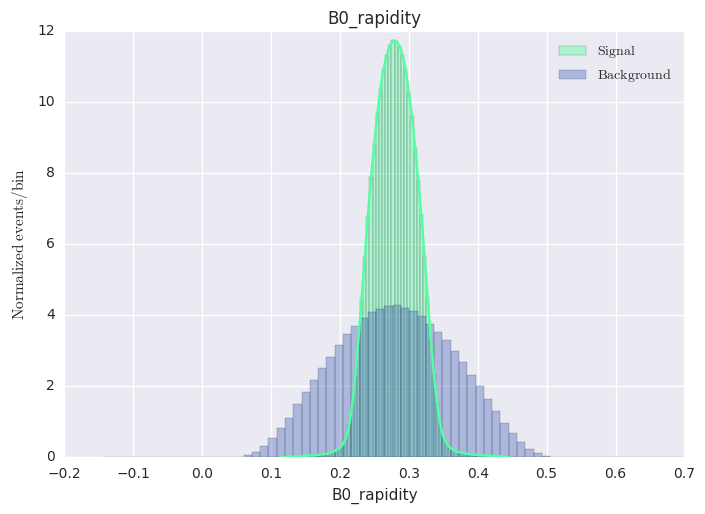

In [47]:
compare_histograms_overlay(df_sig, df_bkg, nbins=70, columns = df_sig.columns[:-1])